# 1 layer Shallow Water Equations 

In this code we will solve the 1 layer shallow water equations, which can be written in vector form as: 

$$
\frac{\partial \mathbf{u}}{\partial t} + \mathbf{u}\cdot \nabla \mathbf{u}  = - g \nabla \eta
$$

$$
\frac{\partial h}{\partial t} + \nabla \cdot (\mathbf{u} h) = 0
$$

$$
h = \eta - \eta_b + H
$$

where $\mathbf{u} = (u,v)$ is the velocity in th x-y plane, $\eta$ is the variation in surface around a mean value, $\eta_b$ is the varition in the bottom around a mean value, $H$ is the mean thickness, $g$ is the gravitational acceleration, and $\mathbf{f} = f_o \mathbf{k}$ is the Coriollis frequency (here we are considering the f-plane).

> For more context see chapter 3 in the Vallis book.

If $\eta_b$ is a constant, we can replace $\eta$ with $h$ in the first equation. 

In [1]:
import numpy as np
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

In [2]:
# Parameters
Lx, Ly = 3000e3, 3000e3
Nx, Ny = 128, 128

delx = Lx/Nx

g = 9.81 
H = 300

dealias = 3/2
stop_sim_time = 5 * 24 * 60 * 60
timestepper = d3.RK222
max_timestep = delx / np.sqrt(g*H)
dtype = np.float64

In [3]:
# Bases
coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(-Lx, Lx), dealias=dealias)
ybasis = d3.RealFourier(coords['y'], size=Ny, bounds=(-Ly, Ly), dealias=dealias)

# Fields
#e = dist.Field(name='e', bases=(xbasis,ybasis)) # surface eta
h = dist.Field(name='h', bases=(xbasis,ybasis)) # surface eta
u = dist.VectorField(coords, name='u', bases=(xbasis,ybasis))
#w = dist.Field(name='w', bases=(xbasis,zbasis))
#tau_p = dist.Field(name='tau_p')

x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist)

In [4]:
problem = d3.IVP([h, u], namespace=locals())

In [5]:
# Equations to be solved
problem.add_equation("dt(u) + g*grad(h)  = - u@grad(u)")
problem.add_equation("dt(h) = - div(u * h)")

{'eqn': Add(dt(<Field 5177899200>), Mul(-1, Mul(-1, Div(Mul(<Field 5178338000>, <Field 5177899200>))))),
 'LHS': dt(<Field 5177899200>),
 'RHS': Mul(-1, Div(Mul(<Field 5178338000>, <Field 5177899200>))),
 'condition': 'True',
 'tensorsig': (),
 'dtype': dtype('float64'),
 'valid_modes': array([[ True, False,  True, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False],
        [ True, False,  True, ...,  True,  True,  True],
        ...,
        [ True, False,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True]], shape=(128, 128)),
 'M': <Field 5177899200>,
 'L': 0,
 'F': Mul(-1, Div(Mul(<Field 5178338000>, <Field 5177899200>))),
 'domain': <dedalus.core.domain.Domain at 0x134a07a10>,
 'matrix_dependence': array([False, False]),
 'matrix_coupling': array([False, False])}

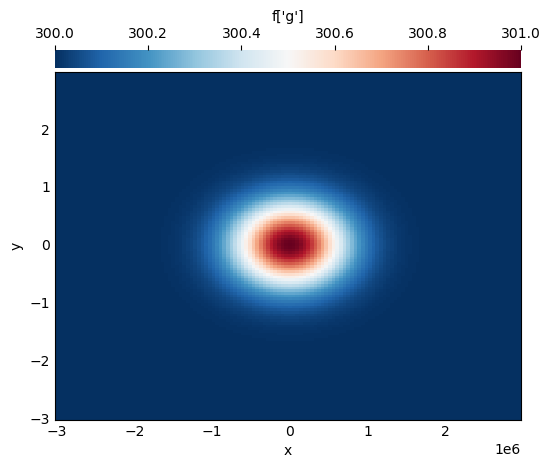

In [6]:
# Setup the initial condition
from dedalus.extras.plot_tools import plot_bot_2d

sigma1 = 500e3

gauss_bump1 = np.exp(-((x)**2 + (y)**2) / (2 * sigma1**2))


A = 1
h['g'] = A * gauss_bump1/ np.max(gauss_bump1) + H


# Plot grid values
plot_bot_2d(h,title="f['g']");

In [7]:
# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

2025-03-31 15:40:25,573 subsystems 0/1 INFO :: Building subproblem matrices 1/64 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 8.3e+01/s
2025-03-31 15:40:25,613 subsystems 0/1 INFO :: Building subproblem matrices 7/64 (~11%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2025-03-31 15:40:25,659 subsystems 0/1 INFO :: Building subproblem matrices 14/64 (~22%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2025-03-31 15:40:25,705 subsystems 0/1 INFO :: Building subproblem matrices 21/64 (~33%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+02/s
2025-03-31 15:40:25,751 subsystems 0/1 INFO :: Building subproblem matrices 28/64 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+02/s
2025-03-31 15:40:25,797 subsystems 0/1 INFO :: Building subproblem matrices 35/64 (~55%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+02/s
2025-03-31 15:40:25,841 subsystems 0/1 INFO :: Building subproblem matrices 42/64 (~66%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+02/s
2025-03-31 15:40:25,886 subsystems 0/1 INFO :: Building subproblem matri

In [8]:
# Setup data output needed for analysis
sim_dt =  30 *60
max_writes = stop_sim_time/sim_dt
data_fname = 'snapshots'
snapshots = solver.evaluator.add_file_handler(data_fname, 
                                              sim_dt=sim_dt, 
                                              max_writes=max_writes)
snapshots.add_task(u, name='uvec')
snapshots.add_task(h, name='height')
snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')
snapshots.add_task(d3.div(u), name='divergence')

#snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')

In [9]:
# CFL (adapt time step as needed)
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, 
             safety=0.5, threshold=0.05,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

In [10]:
# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()


2025-03-31 15:40:26,001 __main__ 0/1 INFO :: Starting main loop
2025-03-31 15:40:26,938 __main__ 0/1 INFO :: Iteration=1, Time=4.320322e+02, dt=4.320322e+02
2025-03-31 15:40:27,161 __main__ 0/1 INFO :: Iteration=11, Time=4.752355e+03, dt=4.320322e+02
2025-03-31 15:40:27,377 __main__ 0/1 INFO :: Iteration=21, Time=9.072677e+03, dt=4.320322e+02
2025-03-31 15:40:27,610 __main__ 0/1 INFO :: Iteration=31, Time=1.339300e+04, dt=4.320322e+02
2025-03-31 15:40:27,827 __main__ 0/1 INFO :: Iteration=41, Time=1.771332e+04, dt=4.320322e+02
2025-03-31 15:40:28,051 __main__ 0/1 INFO :: Iteration=51, Time=2.203364e+04, dt=4.320322e+02
2025-03-31 15:40:28,264 __main__ 0/1 INFO :: Iteration=61, Time=2.635397e+04, dt=4.320322e+02
2025-03-31 15:40:28,477 __main__ 0/1 INFO :: Iteration=71, Time=3.067429e+04, dt=4.320322e+02
2025-03-31 15:40:28,699 __main__ 0/1 INFO :: Iteration=81, Time=3.499461e+04, dt=4.320322e+02
2025-03-31 15:40:28,912 __main__ 0/1 INFO :: Iteration=91, Time=3.931493e+04, dt=4.320322e+

## Visualize the simulation output

In [11]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import dedalus.public as d3
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr

In [12]:
simdata = './snapshots/snapshots_s1.h5'

In [13]:
# See what is in the data files
with h5py.File(simdata, mode='r') as file:
    a_group_key = list(file.keys())
    print(a_group_key)
    
    print(file['scales'])
    print(list(file['scales']))
    print(file['tasks'])
    print(list(file['tasks']))

['scales', 'tasks']
<HDF5 group "/scales" (8 members)>
['constant', 'iteration', 'sim_time', 'timestep', 'wall_time', 'write_number', 'x_hash_0b7dfb2e65990127464432e8c7f9ce562b7d93bd', 'y_hash_0b7dfb2e65990127464432e8c7f9ce562b7d93bd']
<HDF5 group "/tasks" (4 members)>
['divergence', 'height', 'uvec', 'vorticity']


In [14]:
# Actually read in data files
with h5py.File(simdata, mode='r') as file:
    
    h_data = np.squeeze(np.array(file['tasks']['height']))
    print('h shape: ' + str(h_data.shape))
    u_data = np.squeeze(np.array(file['tasks']['uvec']))
    print('u_data: ' + str(u_data.shape))
    vort_data = np.squeeze(np.array(file['tasks']['vorticity']))
    print('vort_data: ' + str(vort_data.shape))
    div_data = np.squeeze(np.array(file['tasks']['divergence']))
    print('div_data: ' + str(div_data.shape))
    #vort_data = np.squeeze(np.array(file['tasks']['vorticity']))
    #div_data = np.squeeze(np.array(file['tasks']['divergence']))
    
    sim_time_ary = np.array(file['scales']['sim_time'])
    print(sim_time_ary.shape)
    
    x = np.array(file['scales'][list(file['scales'])[-2]])
    y = np.array(file['scales'][list(file['scales'])[-1]])
    

h shape: (240, 128, 128)
u_data: (240, 2, 128, 128)
vort_data: (240, 128, 128)
div_data: (240, 128, 128)
(240,)


In [15]:
# Put data in xarray, as it is nice way to keep things organized
ds_sim = xr.Dataset()

ds_sim['h'] = xr.DataArray(h_data, coords = {'time':sim_time_ary, 'x':x, 'y':y})
ds_sim['u'] = xr.DataArray(u_data[:,0,:,:].squeeze(), coords = {'time':sim_time_ary, 'x':y, 'y':y})
ds_sim['v'] = xr.DataArray(u_data[:,1,:,:].squeeze(), coords = {'time':sim_time_ary, 'x':x, 'y':y})

ds_sim['vort'] = xr.DataArray(vort_data, coords = {'time':sim_time_ary, 'x':x, 'y':y})
ds_sim['div'] = xr.DataArray(div_data, coords = {'time':sim_time_ary, 'x':x, 'y':y})


In [16]:
ds_sim

<xarray.Dataset> Size: 157MB
Dimensions:  (time: 240, x: 128, y: 128)
Coordinates:
  * time     (time) float64 2kB 0.0 1.728e+03 3.456e+03 ... 4.286e+05 4.303e+05
  * x        (x) float64 1kB -3e+06 -2.953e+06 ... 2.906e+06 2.953e+06
  * y        (y) float64 1kB -3e+06 -2.953e+06 ... 2.906e+06 2.953e+06
Data variables:
    h        (time, x, y) float64 31MB 300.0 300.0 300.0 ... 299.8 299.8 299.8
    u        (time, x, y) float64 31MB 0.0 0.0 0.0 ... -0.002406 -0.002418
    v        (time, x, y) float64 31MB 0.0 0.0 0.0 ... -0.004814 -0.002418
    vort     (time, x, y) float64 31MB 0.0 0.0 0.0 ... -5.066e-22 2.719e-22
    div      (time, x, y) float64 31MB 0.0 0.0 0.0 ... 1.019e-07 1.029e-07

In [17]:
def create_animation(fun, idx, filename='my-animation.gif', dpi=200, FPS=18, loop=0):
    '''
    See https://pythonprogramming.altervista.org/png-to-gif/
    fun(i) - a function creating one snapshot, has only one input:
        - number of frame i
    idx - range of frames, i in idx
    FPS - frames per second
    filename - animation name
    dpi - set 300 or so to increase quality
    loop - number of repeats of the gif
    '''
    frames = []
    for i in idx:
        fun(i)
        plt.savefig('.frame.png', dpi=dpi, bbox_inches='tight')
        plt.close()
        frames.append(Image.open('.frame.png').convert('RGB'))
        print(f'Frame {i} is created', end='\r')
    os.system('rm .frame.png')
    # How long to persist one frame in milliseconds to have a desired FPS
    duration = 1000 / FPS
    print(f'Animation at FPS={FPS} will last for {len(idx)/FPS} seconds')
    frames[0].save(
        filename, format='GIF',
        append_images=frames[1:],
        save_all=True,
        duration=duration,
        loop=loop)

In [26]:
# This function needs to be modified as needed if you want to make other movies
def plot_fun(time_idx): 
    vmin= H - A/4
    vmax = H + A/4
    fig = plt.figure(figsize=(8, 3))

    plt.subplot(1,2,1)
    ds_sim.h.isel(time=time_idx).plot(x='x', vmin=vmin, vmax=vmax)
    plt.gca().set_aspect('equal')
    plt.title("")

    plt.subplot(1,2,2)
    (ds_sim.vort).isel(time=time_idx).plot(x='x', vmin=-5e-8)
    plt.gca().set_aspect('equal')
    
    plt.title(f"{sim_time_ary[time_idx]/60/60:.2f} hours")

    plt.tight_layout()
    

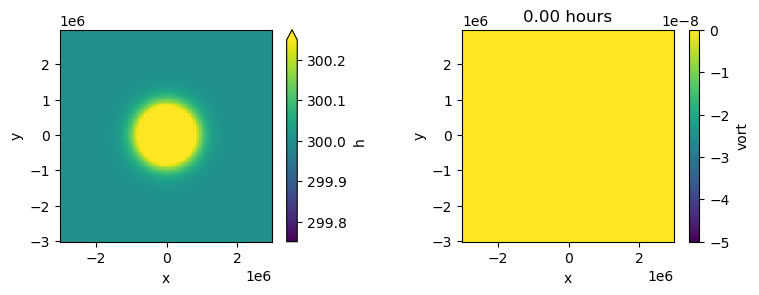

In [27]:
plot_fun(0)

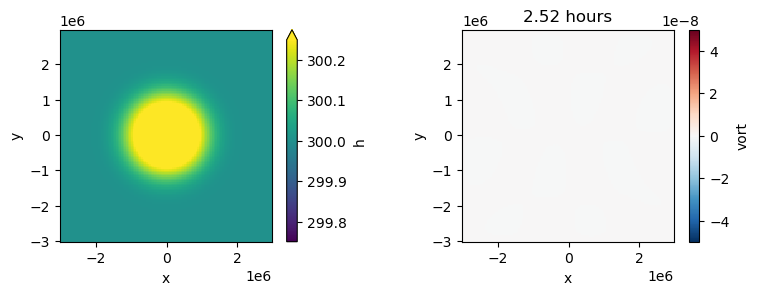

In [28]:
plot_fun(5)

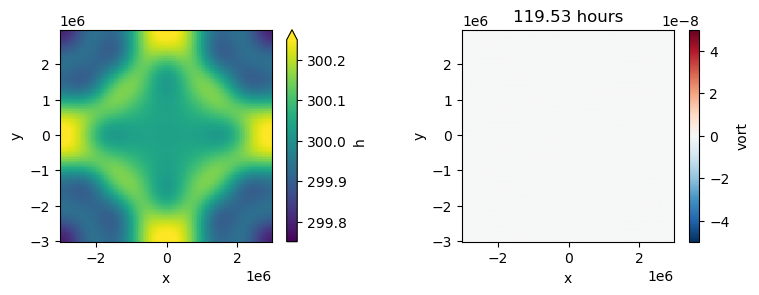

In [29]:
plot_fun(-1)

In [30]:
fname = 'SW.gif'
create_animation(plot_fun, range(0, len(sim_time_ary), 1), filename=fname)

Animation at FPS=18 will last for 13.333333333333334 seconds
